In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.callbacks import EarlyStopping

# Zwite Datensatz:  PO_SC

## Datenvisualisierung:

In [2]:
#  PO_SC Datei einlesen:
PO_SC = pd.read_csv("online_dataset_PO_SC_o2.csv")
PO_SC.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident
0,2022-01-01,PO,Selfcare,SC,123,NaN,NaN,NaN,NaN,1.0,Neujahr,NaN,NaN,NaN
1,2022-01-02,PO,Selfcare,SC,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-04,PO,Selfcare,SC,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-07,PO,Selfcare,SC,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-09,PO,Selfcare,SC,155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
PO_SC = PO_SC.sort_values(by='date')
PO_SC

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident
0,2022-01-01,PO,Selfcare,SC,123,NaN,NaN,NaN,NaN,1.0,Neujahr,NaN,NaN,NaN
1,2022-01-02,PO,Selfcare,SC,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323,2022-01-03,PO,Selfcare,SC,183,2022-01-03,2022-01-03,Einschränkung,1.0,NaN,NaN,NaN,NaN,1.0
2,2022-01-04,PO,Selfcare,SC,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324,2022-01-05,PO,Selfcare,SC,176,2022-01-05,2022-01-05,Einschränkung,1.0,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,2023-05-15,PO,Selfcare,SC,96,2023-05-15,2023-05-17,-,3.0,NaN,NaN,NaN,NaN,1.0
222,2023-05-16,PO,Selfcare,SC,75,2023-05-16,2023-05-17,-,NaN,NaN,NaN,NaN,NaN,1.0
386,2023-05-17,PO,Selfcare,SC,32,2023-05-17,2023-05-17,Einschränkung,1.0,NaN,NaN,NaN,NaN,1.0
188,2023-05-18,PO,Selfcare,SC,39,NaN,NaN,NaN,NaN,1.0,Christi Himmelfahrt,NaN,NaN,NaN


In [4]:
# Anzahl die ["incident_hours"]:
sales_sum = PO_SC["sales"].sum()

print(sales_sum)

92570


Text(0, 0.5, 'Sales')

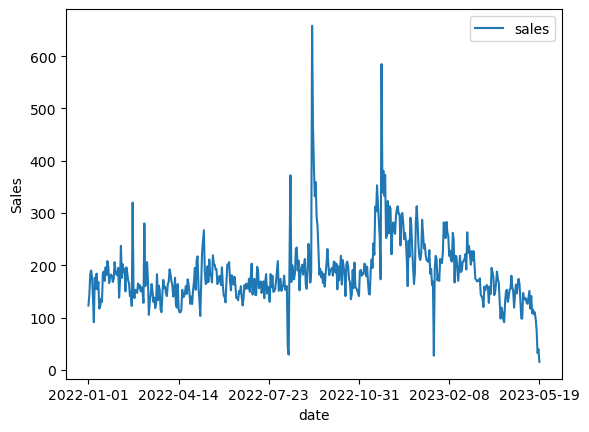

In [5]:
fig, ax = plt.subplots() # Create the figure and axes object
# Plot the first x and y axes:
PO_SC.plot(x = 'date', y = 'sales', ax = ax) 
plt.ylabel('Sales')

In [6]:
frq=PO_SC["is_incident"].value_counts(dropna=False)
frq

is_incident
1.0    331
NaN    170
Name: count, dtype: int64

In [7]:
# Replace NaN values with 0
PO_SC["is_incident"].fillna(0, inplace=True)

# Convert the values to integers, removing decimals
PO_SC["is_incident"] = PO_SC["is_incident"].astype(int)

# Now you can check the value counts again
frq = PO_SC["is_incident"].value_counts(dropna=False)
print(frq)

is_incident
1    331
0    170
Name: count, dtype: int64


In [8]:
#Change to datetime:
PO_SC["date"]= pd.to_datetime(PO_SC["date"])

# Konvertieren Sie die Spalte "date" in das gewünschte Monat-Jahr-Format und speichern Sie sie in einer neuen Spalte "Monat"
PO_SC['Monat'] = pd.to_datetime(PO_SC['date']).dt.to_period('M')

PO_SC.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident,Monat
0,2022-01-01,PO,Selfcare,SC,123,NaN,NaN,NaN,NaN,1.0,Neujahr,NaN,NaN,0,2022-01
1,2022-01-02,PO,Selfcare,SC,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-01
323,2022-01-03,PO,Selfcare,SC,183,2022-01-03,2022-01-03,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2022-01
2,2022-01-04,PO,Selfcare,SC,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-01
324,2022-01-05,PO,Selfcare,SC,176,2022-01-05,2022-01-05,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2022-01


In [9]:
PO_SC.dtypes

date                   datetime64[ns]
product_category               object
reseller_name                  object
reseller                       object
sales                           int64
incident_start_date            object
incident_end_date              object
incident_type                  object
incident_days                 float64
is_holiday                    float64
holiday                        object
release_type                   object
is_release                    float64
is_incident                     int32
Monat                       period[M]
dtype: object

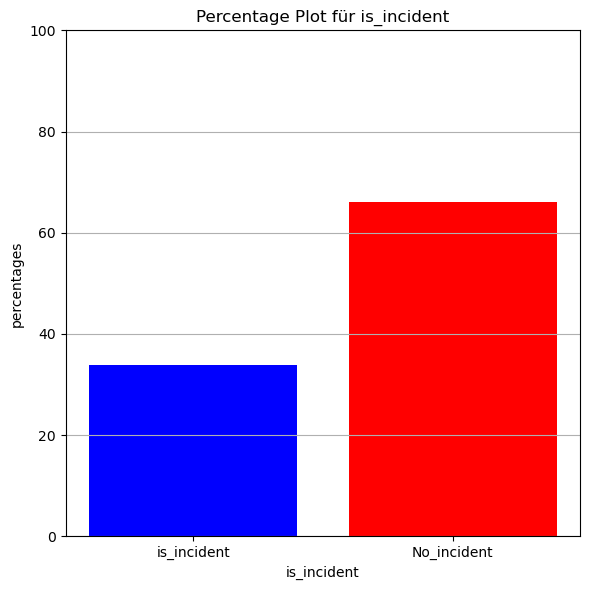

In [10]:
# Zählen Sie die Anzahl der 0 und 1 in der 'binary_var'-Spalte
is_incident_counts = PO_SC['is_incident'].value_counts()

# Berechnen Sie die Prozentsätze
total_samples = len(PO_SC)
percentages = is_incident_counts / total_samples * 100
colors = ['red', 'blue']
# Erstellen Sie den Plot
plt.figure(figsize=(6, 6))
plt.bar(percentages.index, percentages.values, color = colors)
plt.xlabel('is_incident')
plt.ylabel('percentages')
plt.title('Percentage Plot für is_incident')
plt.xticks(percentages.index, labels=['No_incident', 'is_incident'])
plt.ylim(0, 100)  # Stellen Sie die y-Achse auf 0 bis 100 ein
plt.grid(axis='y')
plt.tight_layout()
plt.show()

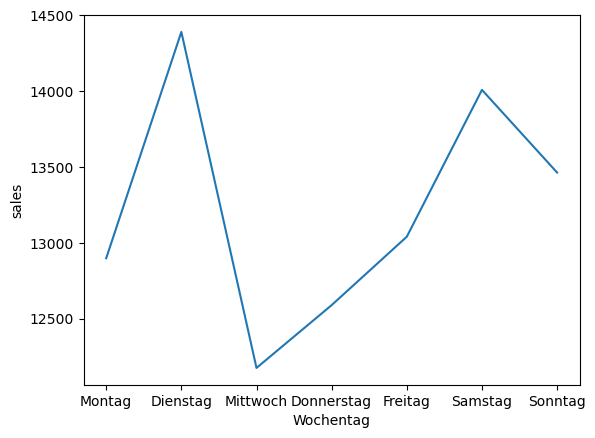

In [11]:
#PO_SC['date'] = pd.to_datetime(PO_SC['date'])

# Extrahiere die Wochentage für jede Zeile in der "Datum"-Spalte
PO_SC['Wochentag'] = PO_SC['date'].dt.day_name()

# Drucke den DataFrame mit der neuen "Wochentag" Spalte
#PO_SC.head()


# Gruppieren Sie die Daten nach 'Wochentag' und berechnen Sie die Summe der Verkäufe für jeden Wochentag
Wochentag_group = PO_SC.groupby('Wochentag')
sales = Wochentag_group['sales'].sum()
Wochentags = [Wochentag for Wochentag, _ in Wochentag_group]

# Plot der Daten
plt.plot(Wochentags, sales)
plt.ylabel('sales')
plt.xlabel('Wochentag')
#plt.xticks(rotation='vertical', size=8)

# Hinzufügen der Wochentagsnamen als X-Achsenbeschriftungen
wochentag_names = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
plt.xticks(Wochentags, wochentag_names)

plt.show()

In [12]:
# Convert the "Monat" to datetime data type if it's not already
PO_SC['Monat'] = PO_SC['Monat'].dt.to_timestamp()

PO_SC['Monat'] = pd.to_datetime(PO_SC['Monat'])

# Use dt.month to extract the month number and categorize based on month number (1 to 12)
PO_SC['Month_k'] = PO_SC['Monat'].dt.month

# Print the DataFrame with the new "Month_k" column
PO_SC.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident,Monat,Wochentag,Month_k
0,2022-01-01,PO,Selfcare,SC,123,NaN,NaN,NaN,NaN,1.0,Neujahr,NaN,NaN,0,2022-01-01,Saturday,1
1,2022-01-02,PO,Selfcare,SC,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-01-01,Sunday,1
323,2022-01-03,PO,Selfcare,SC,183,2022-01-03,2022-01-03,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2022-01-01,Monday,1
2,2022-01-04,PO,Selfcare,SC,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-01-01,Tuesday,1
324,2022-01-05,PO,Selfcare,SC,176,2022-01-05,2022-01-05,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2022-01-01,Wednesday,1


In [13]:
frq= PO_SC['Month_k'].value_counts(dropna=False)
frq

Month_k
1     62
3     61
4     60
2     54
5     50
7     31
8     31
10    31
12    31
6     30
9     30
11    30
Name: count, dtype: int64

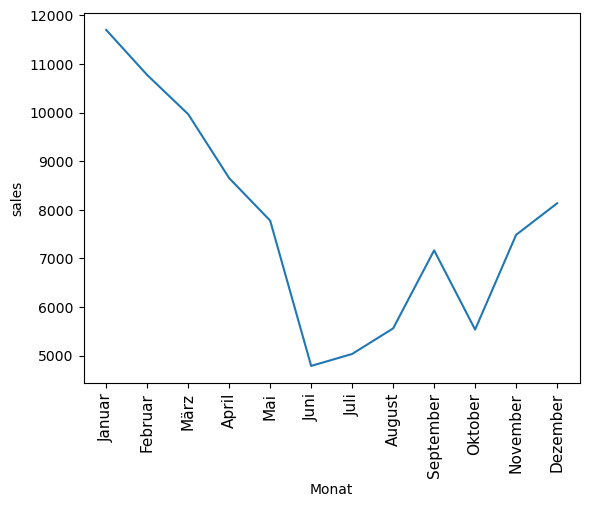

In [14]:
def get_month_name(month_num):
    months = ['Januar', 'Februar', 'März', 'April', 'Mai', 'Juni', 'Juli', 'August', 'September', 'Oktober', 'November', 'Dezember']
    return months[month_num - 1]  # Monatsnummern sind 1-basiert, daher müssen wir 1 abziehen

Monat_group = PO_SC.groupby('Month_k')
sales = Monat_group['sales'].sum()
Monats = [get_month_name(month_num) for month_num in sales.index]

plt.plot(Monats, sales)
plt.ylabel('sales')
plt.xlabel('Monat')
plt.xticks(rotation='vertical', size=11)
plt.show()

In [15]:
# Replace NaN values with 0
PO_SC["is_holiday"].fillna(0, inplace=True)

# Convert the values to integers, removing decimals
PO_SC["is_holiday"] = PO_SC["is_holiday"].astype(int)

# Now you can check the value counts again
frq = PO_SC["is_holiday"].value_counts(dropna=False)
print(frq)

is_holiday
0    487
1     14
Name: count, dtype: int64


In [16]:
PO_SC['is_holiday'] = PO_SC['is_holiday'].astype(str)

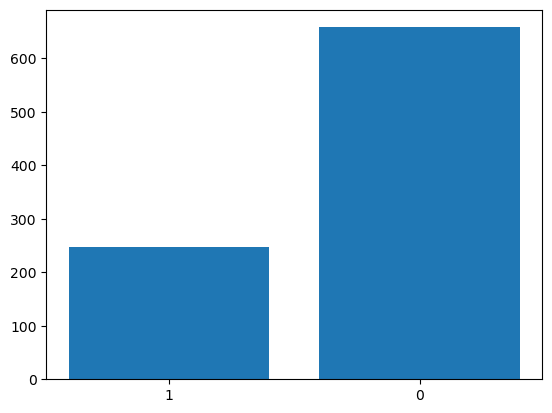

In [17]:
plt.bar(PO_SC['is_holiday'],PO_SC['sales'])
plt.show()

In [18]:
# Erstellen Sie die Dummy-Variablen für "is_holiday"
holiday_dummies = pd.get_dummies(PO_SC['is_holiday'], prefix='Holiday', drop_first=True)

# Erstellen Sie die Dummy-Variablen für "is_incident"
incident_dummies = pd.get_dummies(PO_SC['is_incident'], prefix='Incident', drop_first=True)

# Erstellen Sie die Dummy-Variablen für "Wochentag"
weekday_dummies = pd.get_dummies(PO_SC['Wochentag'], prefix='Weekdays', drop_first=True)

# Erstellen Sie die Dummy-Variablen für "Month_k"
month_dummies = pd.get_dummies(PO_SC['Month_k'], prefix='Month', drop_first=True)

# Erstellen Sie die Dummy-Variablen für "incident_type"
#type_dummies = pd.get_dummies(PO_SC['incident_type'], prefix='type', drop_first=True)


# Fügen Sie die Dummy-Variablen dem DataFrame hinzu
PO_SC = pd.concat([PO_SC, holiday_dummies, incident_dummies, weekday_dummies, month_dummies], axis=1)

PO_SC.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident,Monat,Wochentag,Month_k,Holiday_1,Incident_1,Weekdays_Monday,Weekdays_Saturday,Weekdays_Sunday,Weekdays_Thursday,Weekdays_Tuesday,Weekdays_Wednesday,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,2022-01-01,PO,Selfcare,SC,123,NaN,NaN,NaN,NaN,1,Neujahr,NaN,NaN,0,2022-01-01,Saturday,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2022-01-02,PO,Selfcare,SC,144,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2022-01-01,Sunday,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
323,2022-01-03,PO,Selfcare,SC,183,2022-01-03,2022-01-03,Einschränkung,1.0,0,NaN,NaN,NaN,1,2022-01-01,Monday,1,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2022-01-04,PO,Selfcare,SC,190,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2022-01-01,Tuesday,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
324,2022-01-05,PO,Selfcare,SC,176,2022-01-05,2022-01-05,Einschränkung,1.0,0,NaN,NaN,NaN,1,2022-01-01,Wednesday,1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [19]:
# Daten PO_SC speichern:
PO_SC.to_csv("PO_SC.csv", index = None)

In [20]:
# Daten PO_SC einlesen:
PO_SC=pd.read_csv("PO_SC.csv")
PO_SC.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident,Monat,Wochentag,Month_k,Holiday_1,Incident_1,Weekdays_Monday,Weekdays_Saturday,Weekdays_Sunday,Weekdays_Thursday,Weekdays_Tuesday,Weekdays_Wednesday,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,2022-01-01,PO,Selfcare,SC,123,NaN,NaN,NaN,NaN,1,Neujahr,NaN,NaN,0,2022-01-01,Saturday,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2022-01-02,PO,Selfcare,SC,144,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2022-01-01,Sunday,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2022-01-03,PO,Selfcare,SC,183,2022-01-03,2022-01-03,Einschränkung,1.0,0,NaN,NaN,NaN,1,2022-01-01,Monday,1,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2022-01-04,PO,Selfcare,SC,190,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2022-01-01,Tuesday,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,2022-01-05,PO,Selfcare,SC,176,2022-01-05,2022-01-05,Einschränkung,1.0,0,NaN,NaN,NaN,1,2022-01-01,Wednesday,1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [21]:
PO_SC.columns

Index(['date', 'product_category', 'reseller_name', 'reseller', 'sales',
       'incident_start_date', 'incident_end_date', 'incident_type',
       'incident_days', 'is_holiday', 'holiday', 'release_type', 'is_release',
       'is_incident', 'Monat', 'Wochentag', 'Month_k', 'Holiday_1',
       'Incident_1', 'Weekdays_Monday', 'Weekdays_Saturday', 'Weekdays_Sunday',
       'Weekdays_Thursday', 'Weekdays_Tuesday', 'Weekdays_Wednesday',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12'],
      dtype='object')

# Regression: 

In [24]:
# Definiere die unabhängigen Variablen (X) und die abhängige Variable (y)
X = PO_SC[['Holiday_1', 'Incident_1', 
             'Weekdays_Monday','Weekdays_Saturday','Weekdays_Sunday','Weekdays_Thursday','Weekdays_Tuesday','Weekdays_Wednesday',
             'Month_2', 'Month_3', 'Month_4', 'Month_5','Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Month_12' ]].astype(int)  
y = PO_SC['sales']

# Füge eine Konstante hinzu, um den Intercept zu berücksichtigen
X = sm.add_constant(X)

# Erstelle und fitte das Regressionsmodell
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     14.43
Date:                Fri, 11 Aug 2023   Prob (F-statistic):           2.51e-36
Time:                        21:12:05   Log-Likelihood:                -2659.0
No. Observations:                 501   AIC:                             5358.
Df Residuals:                     481   BIC:                             5442.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                190.2545      9

#  AR 

## Lag_1

In [25]:
import statsmodels.api as sm

# Define the exogenous variables (X) and the endogenous variable (y)
X = PO_SC[['Holiday_1', 'Incident_1', 
           'Weekdays_Monday', 'Weekdays_Saturday', 'Weekdays_Sunday', 'Weekdays_Thursday', 'Weekdays_Tuesday', 'Weekdays_Wednesday',
           'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12']]  
y = PO_SC['sales']

# Fitting the initial OLS model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

# Check the initial Durbin-Watson statistic
dw_initial = sm.stats.stattools.durbin_watson(results.resid)

# Desired target for Durbin-Watson statistic (e.g., 1.5)
target_dw = 1.5

# Define the maximum lag value
max_desired_lag = 365

# Initialize the desired_lag to None
desired_lag = None

# Check if the initial Durbin-Watson statistic is below the target
while dw_initial < target_dw:
    # Increment the desired lag value from 1 up to max_desired_lag
    desired_lag = desired_lag + 1 if desired_lag is not None else 1
    
    # Add the desired lagged term to X (assuming AR structure)
    X[f'Lag_{desired_lag}'] = y.shift(desired_lag)
    X = X.dropna()  # Remove NaN rows introduced by lagging

    # Update y to match the same indices as X after lagging
    y = y[X.index]

    # Re-fit the model with the updated X
    model = sm.OLS(y, X)
    results = model.fit()

    # Check the new Durbin-Watson statistic
    dw_initial = sm.stats.stattools.durbin_watson(results.resid)

    # Break the loop if the maximum desired lag is reached
    if desired_lag >= max_desired_lag:
        break

# Display the results with the desired Durbin-Watson statistic
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     27.80
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           2.36e-67
Time:                        11:37:24   Log-Likelihood:                -2573.8
No. Observations:                 500   AIC:                             5190.
Df Residuals:                     479   BIC:                             5278.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 88.2425     11

# Prognose(lag 1):

In [27]:
import statsmodels.api as sm

# ... (Assuming you have defined X and y here)

# Fitting the initial OLS model
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const)
results = model.fit()
print(results.summary())

# Make forecasts using the model on the original DataFrame 'X'
forecasts = results.predict(X_with_const)

# Add the forecasts as a new column to the original DataFrame 'PO_SC'
PO_SC['sales_forecast_Regression'] = forecasts

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     27.80
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           2.36e-67
Time:                        11:40:44   Log-Likelihood:                -2573.8
No. Observations:                 500   AIC:                             5190.
Df Residuals:                     479   BIC:                             5278.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 88.2425     11

<AxesSubplot:>

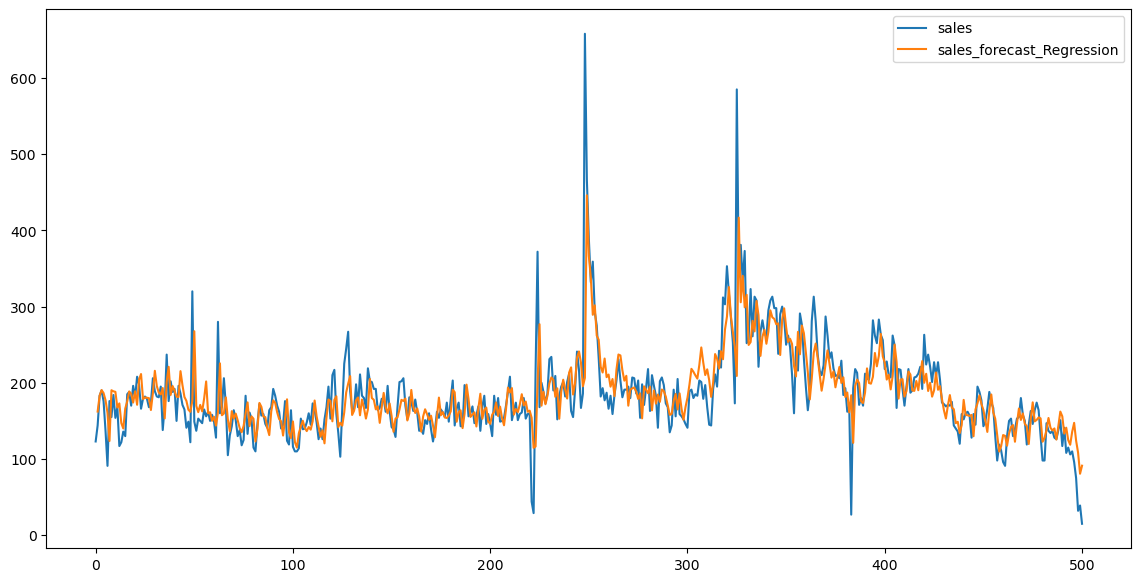

In [28]:
PO_SC[["sales", "sales_forecast_Regression"]].plot(figsize=(14, 7))

# ARIMAX:

In [35]:
exog= PO_SC[['Holiday_1', 'Incident_1', 
             'Weekdays_Monday','Weekdays_Saturday','Weekdays_Sunday','Weekdays_Thursday','Weekdays_Tuesday','Weekdays_Wednesday',
             'Month_2', 'Month_3', 'Month_4', 'Month_5','Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Month_12' ]]  
endog= PO_SC['sales']

# Create the ARIMA model with AR order = 1 and MA order = 0 and provide exogenous variables
order = (1, 0, 0)  # AR order = 1, MA order = 0
model = sm.tsa.ARIMA(endog, exog, order=order)

# Fit the model to the data
results = model.fit()

# Display the results
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  501
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2580.226
Date:                Thu, 27 Jul 2023   AIC                           5204.451
Time:                        15:30:54   BIC                           5297.217
Sample:                             0   HQIC                          5240.849
                                - 501                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                185.1376     14.944     12.389      0.000     155.848     214.427
Holiday_1             -5.2440     15.011     -0.349      0.727     -34.666      24.178
Incident_1          

C:\Users\admin\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Prognose:

In [36]:
exogenous_features= PO_SC[['Holiday_1', 'Incident_1', 
             'Weekdays_Monday','Weekdays_Saturday','Weekdays_Sunday','Weekdays_Thursday','Weekdays_Tuesday','Weekdays_Wednesday',
             'Month_2', 'Month_3', 'Month_4', 'Month_5','Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Month_12' ]]  

# Generate the forecast for the entire data period
forecast = results.predict(exog=exogenous_features)

# Add the forecasted values to the DataFrame
PO_SC["Forecast_ARIMAX"] = forecast

# Print the DataFrame with the forecasted values
PO_SC.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,...,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,sales_forecast_Regression,Forecast_ARIMAX
0,2022-01-01,PO,Selfcare,SC,123,NaN,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,149.990915,168.462883
1,2022-01-02,PO,Selfcare,SC,144,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,193.247723,166.209424
2,2022-01-03,PO,Selfcare,SC,183,2022-01-03,2022-01-03,Einschränkung,1.0,0,...,0,0,0,0,0,0,0,0,204.296234,180.825163
3,2022-01-04,PO,Selfcare,SC,190,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,205.503707,189.100680
4,2022-01-05,PO,Selfcare,SC,176,2022-01-05,2022-01-05,Einschränkung,1.0,0,...,0,0,0,0,0,0,0,0,189.217859,185.665626


<AxesSubplot:>

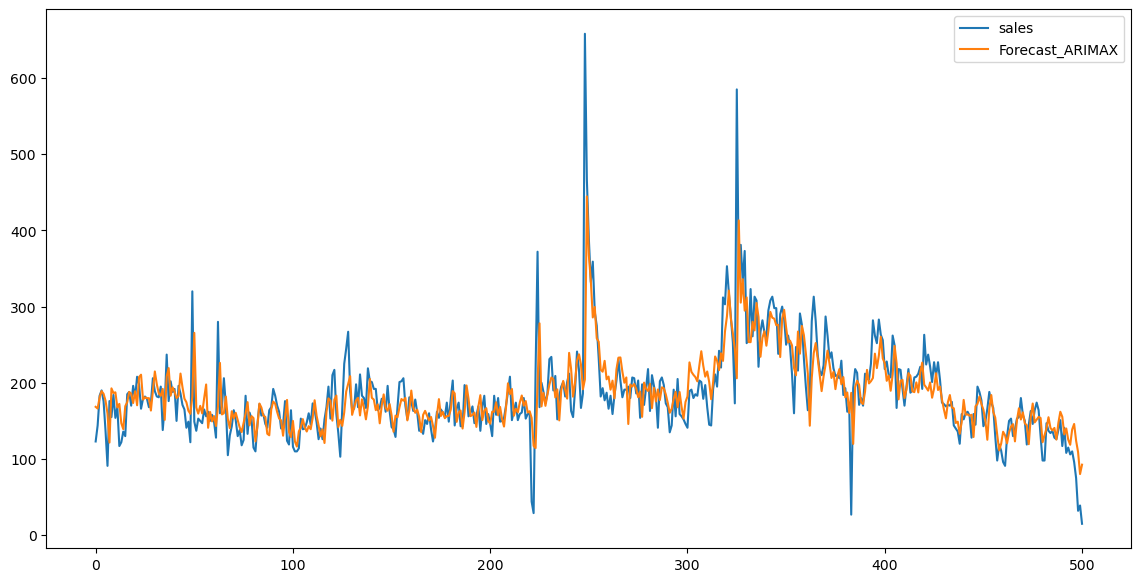

In [37]:
PO_SC[["sales", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

## Opt_Ariamx

In [39]:
# Assuming your dataset "PO_Port" has a column named "sales" representing the time series data
# Replace 'sales' with the actual column name if different
data = PO_SC['sales']

#data = PO_Port[['sales', 'Holiday_1', 'Incident_1', 'Weekdays_Monday', 'Weekdays_Saturday', 'Weekdays_Sunday', 'Weekdays_Thursday', 'Weekdays_Tuesday', 'Weekdays_Wednesday', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12']]


# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d, and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                           order=comb,
                                           seasonal_order=combs,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
print(ans_df.loc[ans_df['aic'].idxmin()])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6692.6871573909975
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6180.420584412802
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5556.227640075511
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5256.963113724616
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5549.5588519364255


C:\Users\admin\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5384.522066810809
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5305.407777877218
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5258.942973853751
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6192.197785088601
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =5842.336238982124
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5451.0280750070915
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =5113.960536124371
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =5445.827259547852
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =5239.796255279141
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =5193.449018563515
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =5115.672217392855
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =5297.231982511761
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =5174.874071520973
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =5542.460112468161
ARIMA (0, 1, 0) x (

In [44]:
import pandas as pd
import statsmodels.api as sm

# Assuming your dataset "PO_Port" has a column named "sales" representing the time series data
# Replace 'sales' with the actual column name if different
data = PO_SC['sales']

# Define the exogenous variables (including the constant if needed)
exog_variables = PO_SC[['Holiday_1', 'Incident_1', 'Weekdays_Monday', 'Weekdays_Saturday', 'Weekdays_Sunday', 'Weekdays_Thursday', 'Weekdays_Tuesday', 'Weekdays_Wednesday', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12']]
exog_variables = sm.add_constant(exog_variables)  # If you need a constant term

# Create the SARIMAX model with AR order = 1, MA order = 0, and seasonal order = (0, 1, 1, 12)
order = (1, 0, 0)  # AR order = 1, MA order = 0
seasonal_order = (1, 0, 0, 12)  # Seasonal order (P, D, Q, S) = (0, 1, 1, 12)
model = sm.tsa.SARIMAX(data, exog=exog_variables, order=order, seasonal_order=seasonal_order)

# Fit the model to the data
results = model.fit()

# Display the results
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                  501
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood               -2579.851
Date:                            Thu, 27 Jul 2023   AIC                           5205.703
Time:                                    15:40:54   BIC                           5302.685
Sample:                                         0   HQIC                          5243.755
                                            - 501                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                184.6592     14.608     12.641      0.000     156.029     213.289
Holiday_1  

C:\Users\admin\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


using lstm

In [25]:
# split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X.iloc[0:train_size,:], X.iloc[train_size:len(X),:]
y_train, y_test = y.iloc[0:train_size], y.iloc[train_size:len(y)]

# scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))

# reshape the data for input to the LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [26]:
# define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train_scaled.shape[1]), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

# Add early stopping callback
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), callbacks=[early_stopping], verbose=2)


Epoch 1/500
13/13 - 1s - loss: 0.2410 - val_loss: 0.1574 - 1s/epoch - 81ms/step
Epoch 2/500
13/13 - 0s - loss: 0.1740 - val_loss: 0.0966 - 37ms/epoch - 3ms/step
Epoch 3/500
13/13 - 0s - loss: 0.1044 - val_loss: 0.0746 - 37ms/epoch - 3ms/step
Epoch 4/500
13/13 - 0s - loss: 0.0739 - val_loss: 0.0839 - 38ms/epoch - 3ms/step
Epoch 5/500
13/13 - 0s - loss: 0.0687 - val_loss: 0.0704 - 40ms/epoch - 3ms/step
Epoch 6/500
13/13 - 0s - loss: 0.0617 - val_loss: 0.0635 - 48ms/epoch - 4ms/step
Epoch 7/500
13/13 - 0s - loss: 0.0582 - val_loss: 0.0627 - 53ms/epoch - 4ms/step
Epoch 8/500
13/13 - 0s - loss: 0.0548 - val_loss: 0.0607 - 53ms/epoch - 4ms/step
Epoch 9/500
13/13 - 0s - loss: 0.0529 - val_loss: 0.0603 - 39ms/epoch - 3ms/step
Epoch 10/500
13/13 - 0s - loss: 0.0516 - val_loss: 0.0613 - 43ms/epoch - 3ms/step
Epoch 11/500
13/13 - 0s - loss: 0.0509 - val_loss: 0.0608 - 40ms/epoch - 3ms/step
Epoch 12/500
13/13 - 0s - loss: 0.0501 - val_loss: 0.0610 - 38ms/epoch - 3ms/step
Epoch 13/500
13/13 - 0s - 

In [27]:
# make predictions with the LSTM model
train_predict = model.predict(X_train_reshaped)
test_predict = model.predict(X_test_reshaped)

# invert the scaling of the predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train_scaled)
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test_scaled)

4/4 [==============================] - 0s 1ms/step


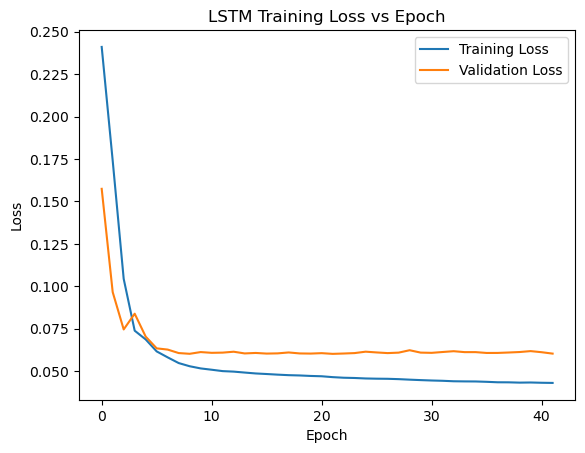

In [28]:
# plot the training and validation loss vs epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Loss vs Epoch')
plt.legend()
plt.show()

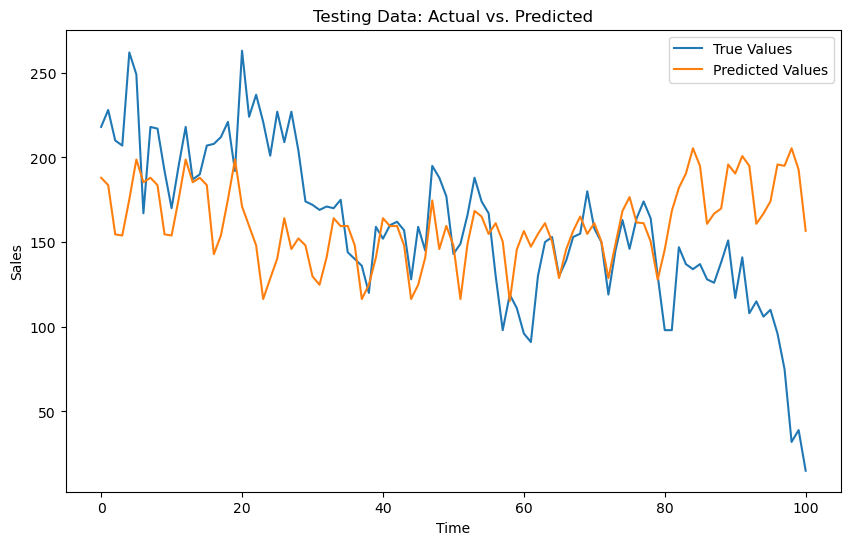

In [29]:
# plot the true values vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='True Values')
plt.plot(test_predict, label='Predicted Values')
plt.legend()
plt.title('Testing Data: Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

In [30]:


# Prepare input data for prediction
incident_0_data = X[X['Incident_1'] == 0].astype(int)
incident_1_data = X[X['Incident_1'] == 1].astype(int)

# Initialize a MinMaxScaler for each feature
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(incident_0_data.shape[1])]

# Scale the data for incident = 0
incident_0_scaled = np.column_stack([scaler.fit_transform(incident_0_data.iloc[:, i].values.reshape(-1, 1)) for i, scaler in enumerate(scalers)])

# Scale the data for incident = 1
incident_1_scaled = np.column_stack([scaler.transform(incident_1_data.iloc[:, i].values.reshape(-1, 1)) for i, scaler in enumerate(scalers)])

incident_0_reshaped = incident_0_scaled.reshape((incident_0_scaled.shape[0], 1, incident_0_scaled.shape[1]))

# Match the number of instances in incident 0 and incident 1 data
incident_1_reshaped = incident_1_scaled[:incident_0_reshaped.shape[0]].reshape((incident_0_reshaped.shape[0], 1, incident_0_reshaped.shape[2]))

# Make predictions
incident_0_predictions = model.predict(incident_0_reshaped)
incident_1_predictions = model.predict(incident_1_reshaped)

# Inverse transform the predictions
incident_0_predictions = scaler.inverse_transform(incident_0_predictions)
incident_1_predictions = scaler.inverse_transform(incident_1_predictions)

# Calculate the difference
difference = incident_1_predictions - incident_0_predictions

6/6 [==============================] - 0s 980us/step


In [33]:
# Calculate the percentage loss in sales due to incident
percentage_loss = (difference / incident_1_predictions) * 100

# Calculate the average absolute loss in sales due to incident
average_absolute_loss = np.mean(np.abs(difference))

# Calculate the general average percentage loss in sales due to incident
general_average_percentage_loss = np.mean(percentage_loss)

print(f"Percentage Loss in Sales due to Incident: {percentage_loss}%")
print(f"General Average Percentage Loss in Sales due to Incident: {general_average_percentage_loss}%")
print(f"Average Absolute Loss in Sales due to Incident: {average_absolute_loss}")

Percentage Loss in Sales due to Incident: [[ 26.68865   ]
 [  8.818916  ]
 [  1.0390843 ]
 [ 16.669409  ]
 [ 13.942891  ]
 [  2.9724348 ]
 [  5.816261  ]
 [ 14.025993  ]
 [-14.818936  ]
 [  5.6446767 ]
 [ -1.7923881 ]
 [ -2.8815413 ]
 [ 16.347637  ]
 [ 29.242546  ]
 [  0.71512926]
 [  0.13950321]
 [ -5.090796  ]
 [ -1.8551704 ]
 [ 16.044456  ]
 [ 18.209415  ]
 [  7.2982616 ]
 [ 36.24325   ]
 [  0.13950321]
 [ -5.090796  ]
 [ 13.220461  ]
 [ 12.923354  ]
 [ 11.531629  ]
 [-10.319808  ]
 [ -3.7185264 ]
 [ -1.3678735 ]
 [-30.483696  ]
 [  3.0388463 ]
 [  7.85439   ]
 [  7.418557  ]
 [ -6.606029  ]
 [-10.519261  ]
 [ -7.992551  ]
 [ 14.064695  ]
 [ 15.005569  ]
 [ 23.733795  ]
 [ -0.1475839 ]
 [ 16.392664  ]
 [ 21.656782  ]
 [  6.9827123 ]
 [ -3.3747838 ]
 [ 12.14801   ]
 [ -4.5646915 ]
 [-28.084406  ]
 [ -4.087822  ]
 [  1.7065289 ]
 [-11.466852  ]
 [-25.584158  ]
 [-24.43333   ]
 [-37.725574  ]
 [-11.214474  ]
 [ -8.363426  ]
 [ -7.802371  ]
 [  1.7789732 ]
 [-20.133839  ]
 [-43.27678   